# Analyze Telco Customer Churn: Prepocessing, Training, and Fittting Data
In preparation for a presentation to Telco executives about customer churn, the CFO is asking for an analysis and predictions for the factors that most impact churn at the company.

This notebook will prepare and model the data to predict churn.

## Summary of Process
1. **Load dataset**: The dataset cleaned in 1-Data_Prep was loaded into a dataframe. 
2. **Create dummy variables**: Since the vast majority of the variables are categorical, one-hot encoding was used to convert the categories into numerical values. One-hot encoding was used instead of binary encoding because there were a maximum of three values for the categorical variables.
3. **Standardize numeric variables**: Give that tenure and monthly/total charges are on different scales, the three numeric values were standardized. Standardization was used instead of min/max scaling as new data might have higher values for all numeric values.
4. **Split into training and testing sets**: A 80/20 test/train split was used as a starting point for the split. This was later changed to 67/33.
5. **Apply machine learning models**: Five machine learning models were developed: logistic regression, K-Nearest Neighbor, random forest, gradient boosting, and cat boost. 
6. **Compare models**: The models were compared using accuracy, F1-scores, lift, and mean cross-validation scores. Logistic regression (F1-Score), random forest (balanced), and cat boost (lift) had the best results.
7. **Hyper parameter tuning**: The three best models were tuned using GridSearchCV. The results demonstrate that each of the Cat Boost is likely the best model.

## Data Sources
- summary.csv: cleaned dataset from the 1-Data_Prep Notebook

## Import Libraries

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Processing and Training
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve, roc_auc_score
from mlxtend.evaluate import lift_score

## File Locations

In [2]:
summary_file = Path.cwd() / "data" / "processed" / f"summary.csv"

In [3]:
df = pd.read_csv(summary_file)

In [4]:
df.head().T

,0,1,2,3,4
gender,Female,Male,Male,Male,Female
SeniorCitizen,No,No,No,No,No
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No
OnlineBackup,Yes,No,Yes,No,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


## Create dummy features for categorical variables via one-hot encoding

In [6]:
X = df

In [7]:
# Filter for the categorical variables
only_objects = X.select_dtypes(include='object')

In [8]:
# Confirm the object columns remain
only_objects.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [9]:
# Create dummy columns using one-hot encoding
X = pd.get_dummies(X, columns=only_objects.columns, drop_first=True)

In [10]:
X.head(10).T

,0,1,2,3,4,5,6,7,8,9
tenure,1.00,34.00,2.00,45.00,2.00,8.00,22.0,10.00,28.00,62.00
MonthlyCharges,29.85,56.95,53.85,42.30,70.70,99.65,89.1,29.75,104.80,56.15
TotalCharges,29.85,1889.50,108.15,1840.75,151.65,820.50,1949.4,301.90,3046.05,3487.95
gender_Male,0.00,1.00,1.00,1.00,0.00,0.00,1.0,0.00,0.00,1.00
SeniorCitizen_Yes,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
Partner_Yes,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.00,0.00
Dependents_Yes,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00,1.00
PhoneService_Yes,0.00,1.00,1.00,0.00,1.00,1.00,1.0,0.00,1.00,1.00
MultipleLines_No phone service,1.00,0.00,0.00,1.00,0.00,0.00,0.0,1.00,0.00,0.00
MultipleLines_Yes,0.00,0.00,0.00,0.00,0.00,1.00,1.0,0.00,1.00,0.00


In [11]:
# Drop the target variable: churn
y = X['Churn_Yes']
X = X.drop(['Churn_Yes'], axis=1)

## Standardize the numeric variables

In [12]:
# Filter for the numeric variables
only_nums = X.select_dtypes(include=['int', 'float'])

In [13]:
# Confirm the numeric columns remain
only_nums.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [14]:
# Instantiate StandardScaler (adapted from DataCamp's Feature Engineering for Machine Learning in Python course)
SS_scaler = StandardScaler()

In [15]:
# Standarize the numeric variables
X['tenure_ss'] = SS_scaler.fit_transform(df[['tenure']])
X['MonthlyCharges_ss'] = SS_scaler.fit_transform(df[['MonthlyCharges']])
X['TotalCharges_ss'] = SS_scaler.fit_transform(df[['TotalCharges']])

In [16]:
# Drop the non-standardized columns
X = X.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1)

In [17]:
X.head().T

,0,1,2,3,4
gender_Male,0.000000,1.000000,1.000000,1.000000,0.000000
SeniorCitizen_Yes,0.000000,0.000000,0.000000,0.000000,0.000000
Partner_Yes,1.000000,0.000000,0.000000,0.000000,0.000000
Dependents_Yes,0.000000,0.000000,0.000000,0.000000,0.000000
PhoneService_Yes,0.000000,1.000000,1.000000,0.000000,1.000000
MultipleLines_No phone service,1.000000,0.000000,0.000000,1.000000,0.000000
MultipleLines_Yes,0.000000,0.000000,0.000000,0.000000,0.000000
InternetService_Fiber optic,0.000000,0.000000,0.000000,0.000000,1.000000
InternetService_No,0.000000,0.000000,0.000000,0.000000,0.000000
OnlineSecurity_No internet service,0.000000,0.000000,0.000000,0.000000,0.000000


## Split into testing and training datasets

In [18]:
#Split into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [19]:
# Confirm size of X_train and X_test
X_train.shape, X_test.shape

((4718, 30), (2325, 30))

## Applying Machine Learning Models
Adapted from https://github.com/debisree/Springboard-Data-Science-Career-Track/blob/master/Capstone_1_predicting_cab_booking_cancellation/predicting-cab-booking-cancellations-ML.ipynb

### Logistic Regression

In [20]:
#Utilize several c parameters with a max iterations of 1000
C_param_range = [0.001,0.01,0.1,1,10,100]

table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
table['C_parameter'] = C_param_range


j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    Logreg = LogisticRegression(penalty = 'l2', max_iter = 1000, C = i,random_state = 42, class_weight='balanced')
    Logreg.fit(X_train,y_train)
    
    # Predict using model
    y_pred_lr = Logreg.predict(X_test)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
table

,C_parameter,Accuracy
0,0.001,0.733763
1,0.010,0.747097
2,0.100,0.744946
3,1.000,0.743226
4,10.000,0.743656
5,100.000,0.743226


Accuracy of Logistic Regression: 0.743225806451613
F1-Score of Logistic Regression: 0.6219126029132362
Lift Score of Logistic Regression: 1.9278216286869383


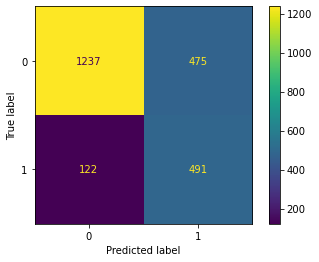

In [21]:
#Create the confusion/classification matrix and find the accuracy
cm= confusion_matrix(y_test,y_pred_lr)
cm_display = ConfusionMatrixDisplay(cm).plot()
Accuracy_lr=Logreg.score(X_test,y_test)
f1_lr = f1_score(y_test, y_pred_lr)
lift_lr = lift_score(y_test, y_pred_lr)

print('Accuracy of Logistic Regression:', Accuracy_lr)
print('F1-Score of Logistic Regression:', f1_lr)
print('Lift Score of Logistic Regression:', lift_lr)
plt.show()

In [22]:
#View the confusion matrix in a simplier format
pd.crosstab(y_test, y_pred_lr, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1237,475,1712
1,122,491,613
All,1359,966,2325


In [23]:
#Print the classification report to see the precision, recall, and f1 scores along with weighted averages
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1712
           1       0.51      0.80      0.62       613

    accuracy                           0.74      2325
   macro avg       0.71      0.76      0.71      2325
weighted avg       0.80      0.74      0.76      2325



In [24]:
#Cross validation
cv_scores_test= cross_val_score(Logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.80645701 0.84681929 0.83851567 0.83487852 0.8612894 ]
Mean cross validation test score: 0.8375919782519764
Mean cross validation train score: 0.8471534796014335
Standard deviation in cv test scores: 0.01802394811085045


### K-Nearest Neighbor

In [25]:
#Fit model for K from 1-10
test_scores = []
train_scores = []

for i in range(1,11):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [26]:
#Print train and test scores for each iteration
for i in range(1,11):
    print('KNN:', i, '\tTrain Score:', train_scores[i-1], '\tTest Score:', test_scores[i-1])

KNN: 1 	Train Score: 0.9970326409495549 	Test Score: 0.7161290322580646
KNN: 2 	Train Score: 0.8749470114455278 	Test Score: 0.7488172043010752
KNN: 3 	Train Score: 0.8658329800763035 	Test Score: 0.7458064516129033
KNN: 4 	Train Score: 0.8427299703264095 	Test Score: 0.7608602150537634
KNN: 5 	Train Score: 0.8357354811360747 	Test Score: 0.7677419354838709
KNN: 6 	Train Score: 0.8329800763035184 	Test Score: 0.7763440860215054
KNN: 7 	Train Score: 0.8266214497668504 	Test Score: 0.7746236559139785
KNN: 8 	Train Score: 0.821534548537516 	Test Score: 0.781505376344086
KNN: 9 	Train Score: 0.8228062738448495 	Test Score: 0.7789247311827957
KNN: 10 	Train Score: 0.8200508690122933 	Test Score: 0.789247311827957


In [27]:
# Determine max and min training scores (Adapted from https://www.kaggle.com/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed)
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max train score 99.70326409495549 % and k = [1]
Max test score 78.92473118279571 % and k = [10]


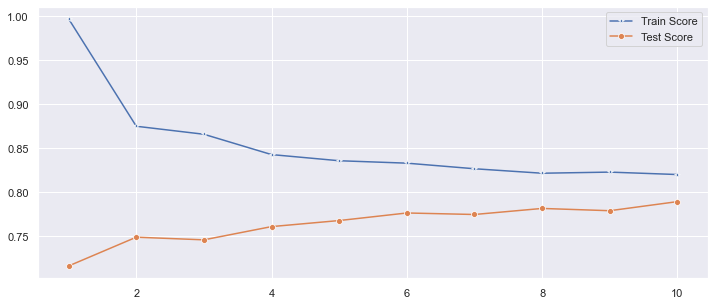

In [28]:
# Plot and test performance by number of neighbors
sns.set()
plt.figure(figsize=(12,5))
p = sns.lineplot(x= range(1,11),y = train_scores,marker='*',label='Train Score')
p = sns.lineplot(x = range(1,11),y = test_scores,marker='o',label='Test Score')

In [29]:
# Fit the model using n_neighbors = 10
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
y_pred_knn=knn.predict(X_test)

Accuracy of K-Nearest Neighbors: 0.789247311827957
F1-Score of K-Nearest Neighbors: 0.5537340619307833
Lift Score of K-Nearest Neighbors: 2.377356586670255


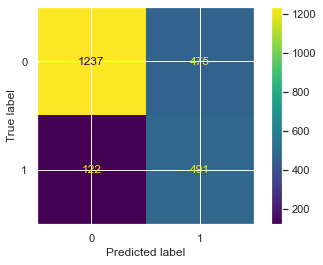

In [30]:
#Create the confusion/classification matrix and find the accuracy
cm_matrix = confusion_matrix(y_test, y_pred_knn)
cm_display = ConfusionMatrixDisplay(cm).plot()
Accuracy_knn=knn.score(X_test,y_test)
f1_knn = f1_score(y_test, y_pred_knn)
lift_knn = lift_score(y_test, y_pred_knn)

print('Accuracy of K-Nearest Neighbors:', Accuracy_knn)
print('F1-Score of K-Nearest Neighbors:', f1_knn)
print('Lift Score of K-Nearest Neighbors:', lift_knn)
plt.show()

In [31]:
#View the confusion matrix in a simplier format
pd.crosstab(y_test, y_pred_knn, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1531,181,1712
1,309,304,613
All,1840,485,2325


In [32]:
#Print the classification report to see the precision, recall, and f1 scores along with weighted averages
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1712
           1       0.63      0.50      0.55       613

    accuracy                           0.79      2325
   macro avg       0.73      0.70      0.71      2325
weighted avg       0.78      0.79      0.78      2325



In [33]:
#Cross validation
cv_scores_test= cross_val_score(knn,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(knn,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_knn))

[0.78614443 0.79388711 0.80301193 0.80524652 0.82342034]
Mean cross validation test score: 0.8023420669411468
Mean cross validation train score: 0.8134012160534683
Standard deviation in cv scores: 0.01254613666992908


### Random Forest

In [34]:
#Fit the model
rf = RandomForestClassifier(bootstrap=True,n_estimators=100,criterion='entropy')
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


Accuracy of Random Forest: 0.7896774193548387
F1-Score of Random Forest: 0.5598559855985598
Lift Score of Random Forest: 2.368609839029855


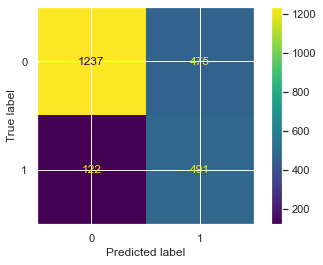

In [35]:
#Create the confusion/classification matrix and find the accuracy
cm_matrix = confusion_matrix(y_test, y_pred_rf)
cm_display = ConfusionMatrixDisplay(cm).plot()
Accuracy_rf=rf.score(X_test,y_test)
f1_rf = f1_score(y_test, y_pred_rf)
lift_rf = lift_score(y_test, y_pred_rf)

print('Accuracy of Random Forest:', Accuracy_rf)
print('F1-Score of Random Forest:', f1_rf)
print('Lift Score of Random Forest:', lift_rf)
plt.show()

In [36]:
#View the confusion matrix in a simplier format
pd.crosstab(y_test, y_pred_rf, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1525,187,1712
1,302,311,613
All,1827,498,2325


In [37]:
#Print the classification report to see the precision, recall, and f1 scores along with weighted averages
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1712
           1       0.62      0.51      0.56       613

    accuracy                           0.79      2325
   macro avg       0.73      0.70      0.71      2325
weighted avg       0.78      0.79      0.78      2325



In [38]:
#Cross validation
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.79634852 0.80779525 0.82380069 0.81701374 0.84410213]
Mean cross validation test score: 0.8178120649852687
Mean cross validation train score: 0.8260211352456533
Standard deviation in cv scores: 0.01605421316919936


### Gradient Boosting

In [39]:
# Fit the model
gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.05 , n_estimators=160, random_state=42, max_depth=9, max_leaf_nodes=100)
gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)

Accuracy of Gradient Boosting: 0.7956989247311828
F1-Score of Gradient Boosting: 0.5777777777777778
Lift Score of Gradient Boosting: 2.4075531453915167


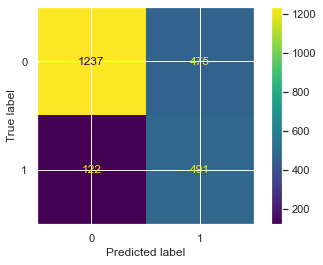

In [40]:
#Create the confusion/classification matrix and find the accuracy
cm_matrix = confusion_matrix(y_test, y_pred_gbc)
cm_display = ConfusionMatrixDisplay(cm).plot()
Accuracy_gbc=gbc.score(X_test,y_test)
f1_gbc = f1_score(y_test, y_pred_gbc)
lift_gbc = lift_score(y_test, y_pred_gbc)

print('Accuracy of Gradient Boosting:', Accuracy_gbc)
print('F1-Score of Gradient Boosting:', f1_gbc)
print('Lift Score of Gradient Boosting:', lift_gbc)
plt.show()

In [41]:
#View the confusion matrix in a simplier format
pd.crosstab(y_test, y_pred_gbc, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1525,187,1712
1,288,325,613
All,1813,512,2325


In [42]:
#Print the classification report to see the precision, recall, and f1 scores along with weighted averages
print(classification_report(y_test,y_pred_gbc))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1712
           1       0.63      0.53      0.58       613

    accuracy                           0.80      2325
   macro avg       0.74      0.71      0.72      2325
weighted avg       0.79      0.80      0.79      2325



In [43]:
#Cross validation
cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbc))

[0.79724466 0.80325479 0.81315076 0.81652641 0.81864213]
Mean cross validation test score: 0.8097637516240216
Mean cross validation train score: 0.8277348076685408
Standard deviation in cv scores: 0.008186883663978423


### Cat Boost

In [44]:
# Fit the model (adapted from https://www.kaggle.com/prashant111/catboost-classifier-in-python)
cbc = CatBoostClassifier(iterations=5, learning_rate=0.1)
cbc.fit(X_train, y_train)

y_pred_cbc = cbc.predict(X_test)

0:	learn: 0.6326633	total: 62.3ms	remaining: 249ms
1:	learn: 0.5866200	total: 64.3ms	remaining: 96.4ms
2:	learn: 0.5492257	total: 66.1ms	remaining: 44.1ms
3:	learn: 0.5153644	total: 68ms	remaining: 17ms
4:	learn: 0.4952900	total: 69.7ms	remaining: 0us


Accuracy of Cat Boosting: 0.7961290322580645
F1-Score of Cat Boosting: 0.5406976744186047
Lift Score of Cat Boosting: 2.5255307634506146


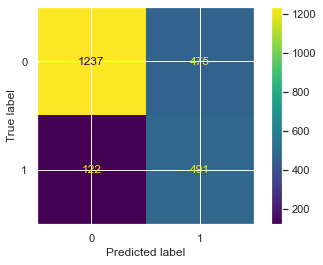

In [45]:
#Create the confusion/classification matrix and find the accuracy
cm_matrix = confusion_matrix(y_test, y_pred_cbc)
cm_display = ConfusionMatrixDisplay(cm).plot()
Accuracy_cbc=cbc.score(X_test,y_test)
f1_cbc = f1_score(y_test, y_pred_cbc)
lift_cbc = lift_score(y_test, y_pred_cbc)

print('Accuracy of Cat Boosting:', Accuracy_cbc)
print('F1-Score of Cat Boosting:', f1_cbc)
print('Lift Score of Cat Boosting:', lift_cbc)
plt.show()

In [46]:
#View the confusion matrix in a simplier format
pd.crosstab(y_test, y_pred_cbc, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1572,140,1712
1,334,279,613
All,1906,419,2325


In [47]:
#Print the classification report to see the precision, recall, and f1 scores along with weighted averages
print(classification_report(y_test,y_pred_cbc))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1712
           1       0.67      0.46      0.54       613

    accuracy                           0.80      2325
   macro avg       0.75      0.69      0.70      2325
weighted avg       0.78      0.80      0.78      2325



In [69]:
#Cross validation
cv_scores_test= cross_val_score(cbc,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(cbc,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_cbc_test= cv_scores_test.mean()
cv_scores_cbc_train= cv_scores_train.mean()
cv_scores_std_cbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_cbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_cbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_cbc))

[0.80139081 0.83574296 0.83939524 0.84231921 0.86851614]
Mean cross validation test score: 0.8374728732504634
Mean cross validation train score: 0.8477869805964939
Standard deviation in cv scores: 0.02142790037329674


## Model Comparison

In [49]:
#Compare model by score and accuracy
myLabels = ['Logistic Regression','KNN', 'Random Forest', 'Gradient Boost', 'Cat Boost']
score_test= [cv_scores_lr_test, cv_scores_knn_test, cv_scores_rf_test, cv_scores_gbc_test, cv_scores_cbc_test]
score_train= [cv_scores_lr_train, cv_scores_knn_train, cv_scores_rf_train, cv_scores_gbc_train, cv_scores_cbc_train]
Accuracy_score = [Accuracy_lr, Accuracy_knn, Accuracy_rf, Accuracy_gbc, Accuracy_cbc]
F1_score = [f1_lr, f1_knn, f1_rf, f1_gbc, f1_cbc]
Lift_score = [lift_lr, lift_knn, lift_rf, lift_gbc, lift_cbc]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab_f1 = pd.DataFrame(list(zip(myLabels, F1_score)), 
               columns =['Algorithm', 'Model F1 score']) 

score_tab_lift = pd.DataFrame(list(zip(myLabels, Lift_score)), 
               columns =['Algorithm', 'Model Lift score']) 


score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 


combined_score_tabs = score_tab_acc.merge(score_tab_f1,on='Algorithm').merge(score_tab_lift,on='Algorithm').merge(score_tab,on='Algorithm')
combined_score_tabs

,Algorithm,Model accuracy score,Model F1 score,Model Lift score,ROC-AUC train score,ROC-AUC test score
0,Logistic Regression,0.743226,0.621913,1.927822,0.847153,0.837592
1,KNN,0.789247,0.553734,2.377357,0.813401,0.802342
2,Random Forest,0.789677,0.559856,2.368610,0.826021,0.817812
3,Gradient Boost,0.795699,0.577778,2.407553,0.827735,0.809764
4,Cat Boost,0.796129,0.540698,2.525531,0.831309,0.818722


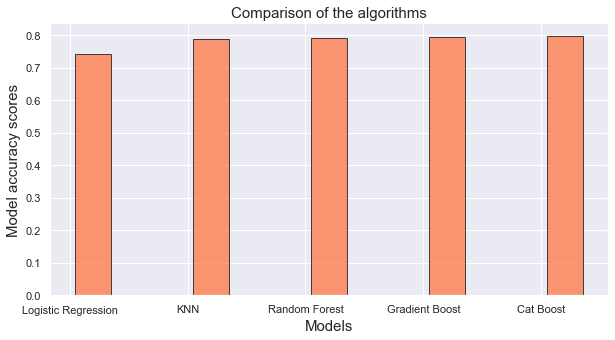

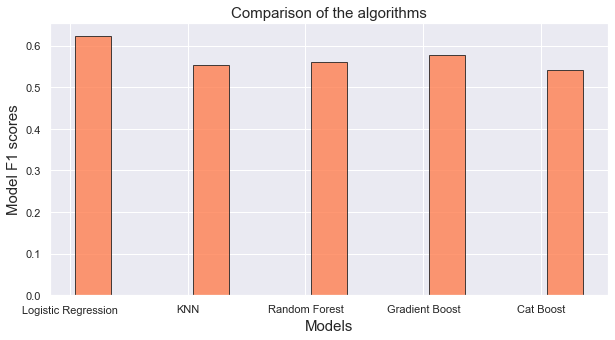

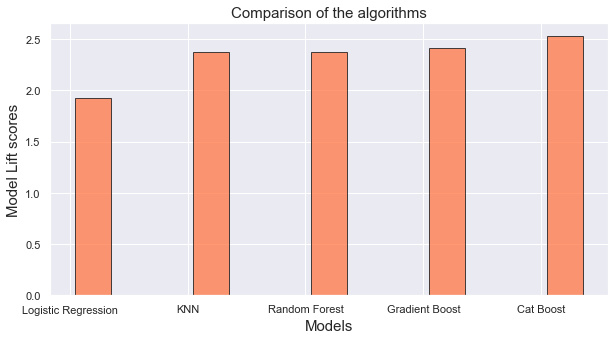

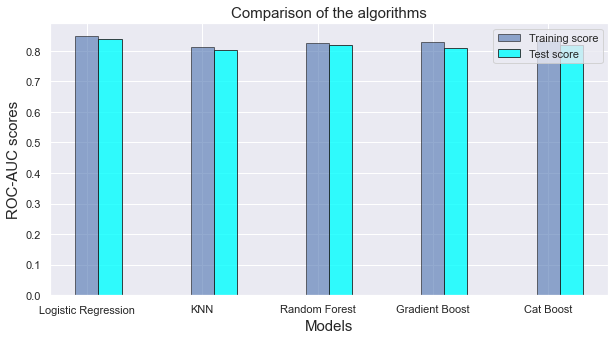

In [50]:
#Plot the accuracy scores:
index=[1, 2, 3, 4, 5]
index_acc=[1.2,2.2,3.2,4.2, 5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model accuracy scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index_acc,Accuracy_score,color='coral',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xticks([1, 2, 3, 4, 5], myLabels)
plt.show()

#Plot the F1 scores:
index=[1, 2, 3, 4, 5]
index_acc=[1.2,2.2,3.2,4.2, 5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model F1 scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index_acc,F1_score,color='coral',alpha=0.8,label='F1 score',edgecolor='k',width=0.3)
plt.xticks([1, 2, 3, 4, 5], myLabels)

plt.show()

#Plott the Lift scores:
index=[1, 2, 3, 4, 5]
index_acc=[1.2,2.2,3.2,4.2, 5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model Lift scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index_acc,Lift_score,color='coral',alpha=0.8,label='Lift score',edgecolor='k',width=0.3)
plt.xticks([1, 2, 3, 4, 5], myLabels)

plt.show()

#Plot the ROC-AUC train/test scores:

index=[1, 2, 3, 4, 5]
index_acc=[1.2,2.2,3.2,4.2, 5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1, 2, 3, 4, 5], myLabels)
plt.legend()
plt.show()

## Hyper Parameter Tuning

### Logistic Regression

In [51]:
# Do a grid search
lr = LogisticRegression(penalty='l2', max_iter = 1000)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

gs = GridSearchCV(estimator=lr, param_grid=param_grid)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

LogisticRegression(C=0.1, max_iter=1000)
0.8022478296816866


In [52]:
# Fit the model using the grid search parameters
lr = LogisticRegression(C=0.1, penalty='l2', max_iter = 1000)
lr.fit(X_train, y_train)
y_predictions_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_predictions_lr)
f1_lr = f1_score(y_test, y_predictions_lr)
lift_lr = lift_score(y_test, y_pred_lr)
cv_lr = cross_val_score(lr, X_test, y_test,scoring='roc_auc').mean()
print('Accuracy:', acc_lr)
print('F1-Score:', f1_lr)
print('Lift Score:', lift_lr)
print('CV Score:', cv_lr)

Accuracy: 0.8025806451612904
F1-Score: 0.5883408071748878
Lift Score: 1.9278216286869383
CV Score: 0.8357484735292795


                                 Features  Importance scores
0                             gender_Male           0.004929
1                       SeniorCitizen_Yes           0.010815
2                             Partner_Yes           0.046984
3                          Dependents_Yes           0.058881
4                        PhoneService_Yes           0.059218
5          MultipleLines_No phone service           0.086302
6                       MultipleLines_Yes           0.086302
7             InternetService_Fiber optic           0.086302
8                      InternetService_No           0.086302
9      OnlineSecurity_No internet service           0.086302
10                     OnlineSecurity_Yes           0.086302
11       OnlineBackup_No internet service           0.086302
12                       OnlineBackup_Yes           0.156254
13   DeviceProtection_No internet service           0.165868
14                   DeviceProtection_Yes           0.202656
15        TechSupport_No

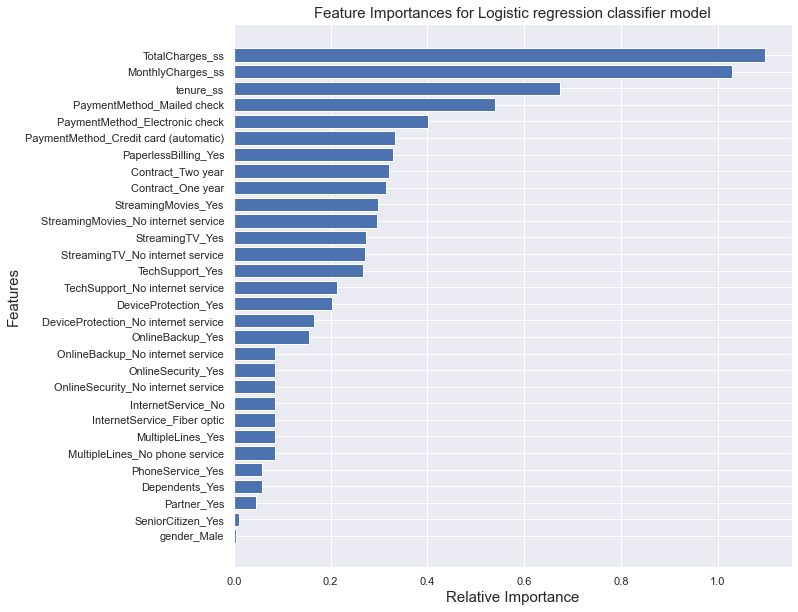

In [73]:
#Feature importances and visual comparison (adapted from: https://stackoverflow.com/questions/66750706/sklearn-important-features-error-when-using-logistic-regression)
imp = abs(lr.coef_[0])
imp = np.sort(imp)
features = X
feat_importances = pd.Series(imp)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)
index = list(range(1,31))
plt.figure(figsize=(10,10))
_=plt.barh(index,imp, align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Logistic regression classifier model',fontsize=15)
plt.show()

In [75]:
tab.to_csv('tab.csv', index=False)

In [54]:
#Calculate the ROC-AUC score
y_scores_lr = lr.predict_proba(X_test)
y_scores_lr = y_scores_lr[:,1]
auroc = roc_auc_score(y_test, y_scores_lr)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8365214930402037


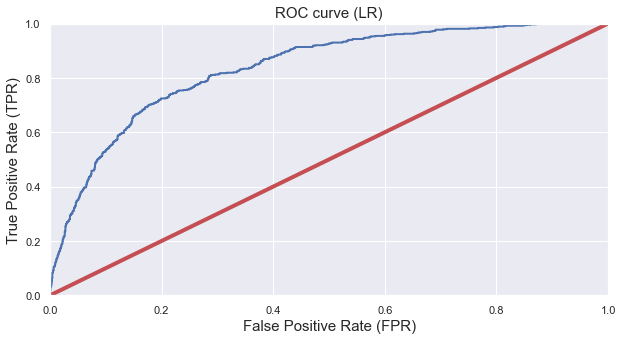

In [55]:
#Create the ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_lr)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (LR)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

### Random Forest

In [56]:
# Do a grid search
rf = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 4, 10,12,16], 
              "n_estimators": [50, 100,400,700,1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

RandomForestClassifier(min_samples_leaf=10, n_jobs=-1, random_state=1)
0.8018234175416689


In [57]:
# Fit the model using the grid search parameters
rf = RandomForestClassifier(min_samples_leaf=10, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)
y_predictions_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_predictions_rf)
f1_rf = f1_score(y_test, y_predictions_rf)
cv_rf = cross_val_score(rf, X_test, y_test,scoring='roc_auc').mean()
lift_rf = lift_score(y_test, y_pred_rf)
print('Accuracy:', acc_rf)
print('F1-Score:', f1_rf)
print('Lift Score:', lift_rf)
print('CV Score:', cv_rf)

Accuracy: 0.7982795698924732
F1-Score: 0.567741935483871
Lift Score: 2.368609839029855
CV Score: 0.836930185103483


                                 Features  Importance scores
0                             gender_Male           0.002443
1                       SeniorCitizen_Yes           0.002547
2                             Partner_Yes           0.005396
3                          Dependents_Yes           0.005446
4                        PhoneService_Yes           0.007510
5          MultipleLines_No phone service           0.007571
6                       MultipleLines_Yes           0.008937
7             InternetService_Fiber optic           0.009133
8                      InternetService_No           0.009155
9      OnlineSecurity_No internet service           0.009167
10                     OnlineSecurity_Yes           0.009485
11       OnlineBackup_No internet service           0.010307
12                       OnlineBackup_Yes           0.010761
13   DeviceProtection_No internet service           0.011401
14                   DeviceProtection_Yes           0.011828
15        TechSupport_No

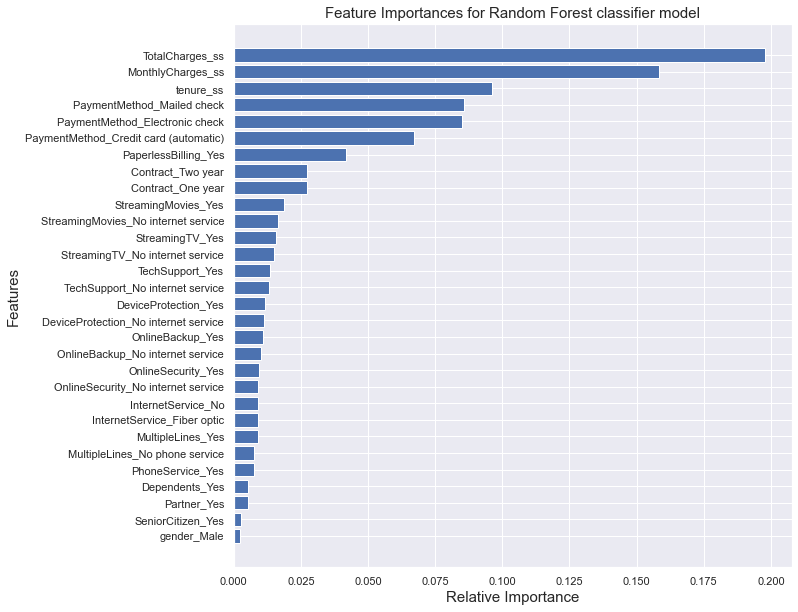

In [58]:
#Feature importances:
features = X
importances = list(rf.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

#Visual comparison:
plt.figure(figsize=(10,10))
#indices = np.argsort(importances)
index = list(range(1,31))
_=plt.barh(index,imp, align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Random Forest classifier model',fontsize=15)
plt.show()

In [59]:
#Calculate the ROC-AUC score
y_scores_rf = rf.predict_proba(X_test)
y_scores_rf = y_scores_rf[:,1]
auroc = roc_auc_score(y_test, y_scores_rf)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8425307969081124


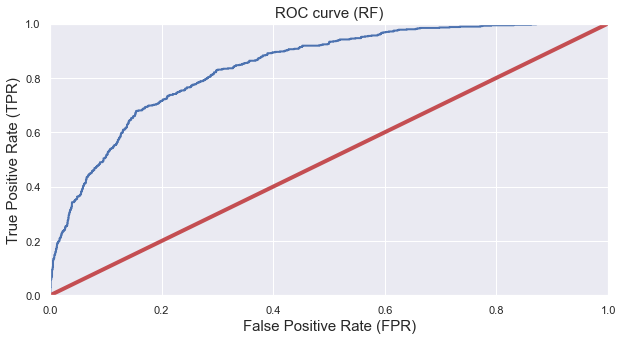

In [60]:
#Create the ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_rf)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (RF)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

### Cat Boost

In [61]:
# Use Grid Search
cbc = CatBoostClassifier(verbose=False)

# Parameter grid from https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-classification
param_grid = {'depth': [4,5,6,7,8,9, 10],
              'learning_rate': [0.01,0.02,0.03,0.04],
              'iterations': [10,20,30,40,50,60,70,80,90,100]
                 }

gs = GridSearchCV(estimator=cbc, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_params_) 
print(gs.best_score_)


{'depth': 7, 'iterations': 80, 'learning_rate': 0.04}
0.8045794516995072


In [62]:
# Fit the model using the grid search parameters
cbc = CatBoostClassifier(depth = 7, iterations = 80, learning_rate = 0.04, verbose=False)
cbc.fit(X_train, y_train)
y_predictions_cbc = cbc.predict(X_test)
acc_cbc = accuracy_score(y_test, y_predictions_cbc)
f1_cbc = f1_score(y_test, y_predictions_cbc)
cv_cbc = cross_val_score(cbc, X_test, y_test,scoring='roc_auc').mean()
lift_cbc = lift_score(y_test, y_pred_cbc)
print('Accuracy:', acc_cbc)
print('F1-Score:', f1_cbc)
print('Lift Score:', lift_cbc)
print('CV Score:', cv_cbc)

Accuracy: 0.803010752688172
F1-Score: 0.5743494423791821
Lift Score: 2.5255307634506146
CV Score: 0.8374728732504634


                                 Features  Importance scores
0                             gender_Male           0.000000
1                       SeniorCitizen_Yes           0.099697
2                             Partner_Yes           0.206676
3                          Dependents_Yes           0.222266
4                        PhoneService_Yes           0.399958
5          MultipleLines_No phone service           0.589318
6                       MultipleLines_Yes           0.637494
7             InternetService_Fiber optic           0.938698
8                      InternetService_No           1.256228
9      OnlineSecurity_No internet service           1.371303
10                     OnlineSecurity_Yes           1.421351
11       OnlineBackup_No internet service           1.518571
12                       OnlineBackup_Yes           1.633179
13   DeviceProtection_No internet service           1.815217
14                   DeviceProtection_Yes           2.018611
15        TechSupport_No

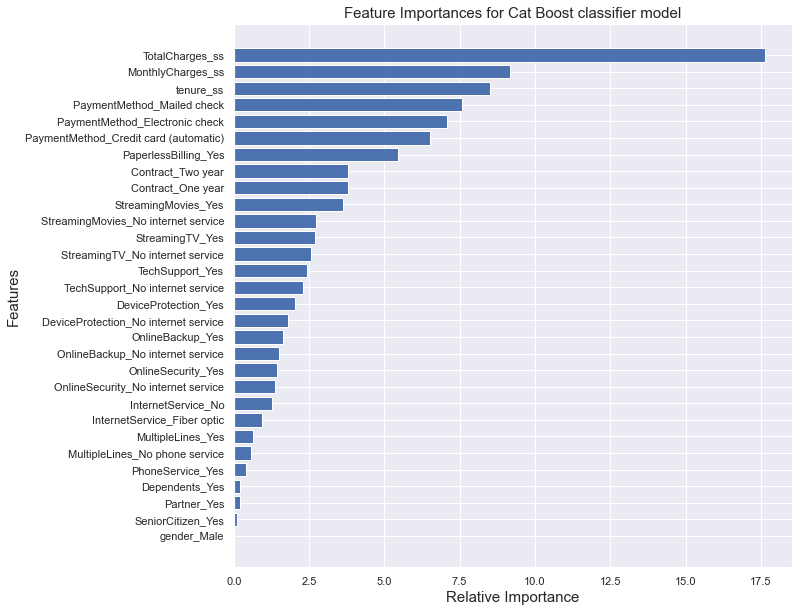

In [63]:
#Feature importances:
features = X
importances = list(cbc.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

#Visual comparison:
plt.figure(figsize=(10,10))
index = list(range(1,31))
_=plt.barh(index,imp, align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Cat Boost classifier model',fontsize=15)
plt.show()

In [64]:
#Calculate the ROC-AUC score
y_scores_cbc = cbc.predict_proba(X_test, verbose=None)
y_scores_cbc = y_scores_cbc[:,1]
auroc = roc_auc_score(y_test, y_scores_cbc)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8418938002164932


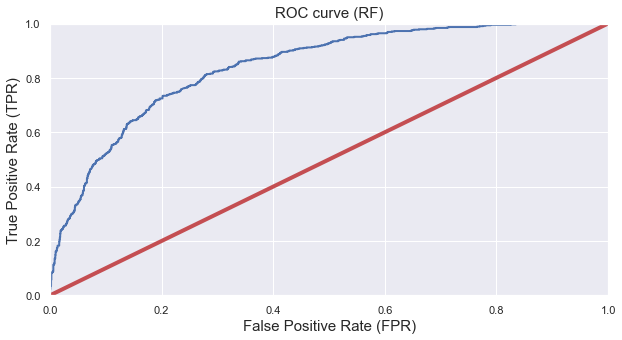

In [65]:
#Create the ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_cbc)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (RF)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [66]:
#Compare model by score and accuracy
myLabels = ['Logistic Regression','Random Forest','Cat Boost']
accuracy = [acc_lr, acc_rf, acc_cbc]
f1 = [f1_lr, f1_rf, f1_cbc]
cv = [cv_lr, cv_rf, cv_cbc]
lift = [lift_lr, lift_rf, lift_cbc]

score_tab_acc = pd.DataFrame(list(zip(myLabels, accuracy)), 
               columns =['Algorithm', 'Accuracy']) 

score_tab_f1 = pd.DataFrame(list(zip(myLabels, f1)), 
               columns =['Algorithm', 'F1']) 

score_tab_lift = pd.DataFrame(list(zip(myLabels, lift)), 
               columns =['Algorithm', 'Lift']) 

score_tab_cv = pd.DataFrame(list(zip(myLabels, cv)), 
               columns =['Algorithm', 'CV']) 

In [67]:
combined_scores = score_tab_acc.merge(score_tab_f1,on='Algorithm').merge(score_tab_lift,on='Algorithm').merge(score_tab_cv,on='Algorithm')
combined_scores

,Algorithm,Accuracy,F1,Lift,CV
0,Logistic Regression,0.802581,0.588341,1.927822,0.835748
1,Random Forest,0.798280,0.567742,2.368610,0.836930
2,Cat Boost,0.803011,0.574349,2.525531,0.837473
